In [1]:
# This code will connect the Colab program to the Google Drive folder
# It will create a pop-up window where access has to be granted
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import datetime
import numpy as np
import pandas as pd

import torch.nn as nn
import math
from torch import nn, Tensor

import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import timedelta

import random
import sys

# Path to the Transformer folder
path = "/content/drive/My Drive/Timeseries_Transformer" ########### This line should be changed ###########

In [3]:
# Checks if the program is running with a GPU
assert torch.cuda.is_available() == True, f"GPU is not available, please select another runtime type in Colab that does support GPU."

# Sets the device to be the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Sets path read in code from the Transformer folder
sys.path.insert(0, path)

import utils
import Transformer_Model as tsModel

In [5]:
# Parameters:
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048

batch_first = False

### Transformer forecast

In [6]:
SPX = pd.read_csv(f'{path}/Data/SPX_data.csv')
SPX.insert(0, 'Date', pd.to_datetime(SPX['End']))
SPX

,Date,Ticker,Start,End,Mean,Zero,Std,Target,Momentum3,Momentum6,...,42,43,44,45,46,47,48,49,50,51
0,2017-12-25,1831877D US Equity,2016-12-26,2017-12-25,0.000805,-0.035522,0.022673,-4.149051,-0.005292,-0.003757,...,0.564133,-1.039530,-1.746515,-0.358979,-0.803372,0.112289,-1.080879,-1.357099,-1.357780,-0.459860
1,2017-12-25,NWS US Equity,2016-12-26,2017-12-25,0.006161,-0.234380,0.026285,1.740933,0.011705,0.005853,...,-0.370024,0.171066,0.826194,2.416598,0.609764,-0.234380,1.627532,0.104797,-0.915784,0.221247
2,2017-12-25,NWL US Equity,2016-12-26,2017-12-25,-0.008502,0.158421,0.053666,0.840851,-0.036611,-0.022111,...,-1.006160,0.297099,-4.912799,-1.319486,0.386110,0.775260,1.520905,-0.370370,0.110153,0.055427
3,2017-12-25,NVDA US Equity,2016-12-26,2017-12-25,0.014000,-0.230973,0.060613,-1.752847,0.020120,0.015903,...,-0.340519,0.363992,0.231120,0.003457,-0.118855,-0.214846,-2.496822,0.461382,0.041360,-0.451684
4,2017-12-25,NUE US Equity,2016-12-26,2017-12-25,-0.001468,0.043076,0.034088,4.294637,0.002291,-0.001043,...,1.169786,-0.444531,-0.203797,-1.133834,-0.030739,0.195812,1.563047,1.240250,0.395275,1.225292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37809,2023-11-20,EMR US Equity,2022-11-21,2023-11-20,-0.000093,0.003083,0.030050,-0.307408,-0.001337,0.002453,...,-0.166870,-0.505245,-0.817716,0.058678,0.169292,-2.206649,-0.634135,1.218437,-1.915703,1.033242
37810,2023-11-20,EMN US Equity,2022-11-21,2023-11-20,-0.001622,0.053652,0.030228,5.387551,-0.015819,-0.005589,...,-0.101201,-0.874311,-0.295140,-1.183246,0.366115,-1.643209,2.547589,0.525454,0.299951,2.175512
37811,2023-11-20,ELV US Equity,2022-11-21,2023-11-20,-0.000133,0.004397,0.030180,0.987143,-0.002980,-0.000690,...,-0.481491,0.840971,-1.022083,0.955629,0.699967,-0.781971,-0.271803,0.481663,0.501482,0.288992
37812,2023-11-20,EIX US Equity,2022-11-21,2023-11-20,0.001728,-0.057169,0.030222,1.941225,-0.011389,-0.005881,...,0.576061,-1.763665,-3.072775,0.740811,1.804970,-2.286462,0.399817,0.559762,-0.912436,1.722577


In [7]:

# Choose the model version to forecast on
model_version = 'MSE_model'
#model_version = 'MSE_single'
#model_version = 'MSE_T2V'
#model_version = 'WMSE_model'
#model_version = 'AdjMSE_model'
#model_version = 'NegCorr_model'
#model_version = 'LSTM_model'
#model_version = 'LSTM_single'
#model_version = 'MSE_test2'

if model_version == 'LSTM_model':

  input_size = 1
  output_sequence_length  = 1
  hidden_size = 100

  # Define the LSTM model
  class LSTM(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
          super(LSTM, self).__init__()
          self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
          self.fc = torch.nn.Linear(hidden_size, output_sequence_length)

      def forward(self, x):
          out, _ = self.lstm(x)
          out = self.fc(out[:, -1, :])  # Take the output from the last time step
          return out

  model = LSTM(input_size, hidden_size, output_sequence_length).cuda()

elif model_version == 'LSTM_single':

  input_size = 1
  output_sequence_length  = 4
  hidden_size = 100

  # Define the LSTM model
  class LSTM(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
          super(LSTM, self).__init__()
          self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
          self.fc = torch.nn.Linear(hidden_size, output_sequence_length)

      def forward(self, x):
          out, _ = self.lstm(x)
          out = self.fc(out[:, -1, :])  # Take the output from the last time step
          return out

  model = LSTM(input_size, hidden_size, output_sequence_length).cuda()

else:
  batch_size = 128
  enc_seq_len = 48 # length of input given to encoder
  output_sequence_length = 1 # target sequence length. The length we want to predict

  # Define the model
  model = tsModel.TimeSeriesTransformer(
                                        input_size=1,
                                        dec_seq_len=enc_seq_len,
                                        batch_first=batch_first,
                                        num_predicted_features=1,
                                        n_encoder_layers = n_encoder_layers,
                                        n_decoder_layers = n_decoder_layers,
                                        n_heads = n_heads,
                                        PE = 'original',
                                        batch_size = batch_size
                                        ).cuda()


model.load_state_dict(torch.load(f'{path}/Models/{model_version}/Model_parameters.pth'))
#model.load_state_dict(torch.load(f'{path}/Models/{model_version}/Training parameters/Parameters_epoch_55.pth'))

 # Turns off the training, since we want to calculate the validation loss
model.train(False)

start_date = pd.to_datetime('2017-12-25')

collect_df = pd.DataFrame([])

while start_date <= pd.to_datetime('2023-12-11'):

  data = SPX[SPX['Date'] == start_date].reset_index(drop=True)

  # This line makes sure that the model when doing this prediction never sees the last 4 (the -4 in the code) observations that we want to predict.
  src = torch.tensor(data.iloc[:, 8:-4].values).to(torch.float32).to(device)

  prediction_overall = pd.DataFrame([])

  if model_version == 'LSTM_model':
    y_vpred = model.forward( src.unsqueeze(-1)  )

  elif model_version == 'LSTM_single':
    y_vpred = model.forward( src.unsqueeze(-1)  )

  else:
    # Only thing thats going on here is that we transform the data to fit the model input
    src = torch.transpose(src, 0, 1).unsqueeze(-1)


    # Running the data through the prediction model
    y_vpred = utils.run_encoder_decoder_inference(
                                                    model=model,
                                                    src=src,
                                                    forecast_window=output_sequence_length,
                                                    batch_size=src.shape[1],
                                                    device = device
                                                    )

  # Multistep model
  if output_sequence_length == 1:

    if model_version == 'LSTM_model':
      prediction = pd.DataFrame(y_vpred.squeeze(-1).cpu().detach().numpy(), columns= ['Prediction'])
    else:
      prediction = pd.DataFrame(y_vpred.squeeze(-1).sum(axis=0).cpu().detach().numpy(), columns= ['Prediction'])
    pred_df = pd.concat([data.iloc[:, :11], data.iloc[:, -4:], prediction], axis=1)
    pred_df['Real'] = pred_df['Target']

    # Revert scaling
    pred_df['prediction'] = ((pred_df['Prediction'] * pred_df['Std']) + pred_df['Mean'])
    pred_df['real'] = (pred_df['Real'] * pred_df['Std']) + pred_df['Mean']

    # Revert the prediction to raw returns
    pred_df['Raw return predicted'] = np.exp(pred_df['prediction']) - 1

    # Revert scaling (Used for checking the mathcing of dates later is correct)
    pred_df['48'] = (pred_df['48'] * pred_df['Std']) + pred_df['Mean']
    pred_df['49'] = (pred_df['49'] * pred_df['Std']) + pred_df['Mean']
    pred_df['50'] = (pred_df['50'] * pred_df['Std']) + pred_df['Mean']
    pred_df['51'] = (pred_df['51'] * pred_df['Std']) + pred_df['Mean']

  # Single step model
  elif output_sequence_length == 4:

    if model_version == 'LSTM_single':
      prediction = pd.DataFrame(y_vpred.cpu().detach().numpy(), columns=['0', '1', '2', '3'])
    else:
      prediction = pd.DataFrame(y_vpred.squeeze(-1).cpu().detach().numpy().T, columns=['0', '1', '2', '3'])
    pred_df = pd.concat([data.iloc[:, :11], data.iloc[:, -4:], prediction], axis=1)

    pred_df['Real'] = pred_df['48'] + pred_df['49'] + pred_df['50'] + pred_df['51']
    pred_df['Prediction'] = pred_df['0'] + pred_df['1'] + pred_df['2'] + pred_df['3']

    # Revert scaling
    pred_df['0'] = (pred_df['0'] * pred_df['Std']) + pred_df['Mean']
    pred_df['1'] = (pred_df['1'] * pred_df['Std']) + pred_df['Mean']
    pred_df['2'] = (pred_df['2'] * pred_df['Std']) + pred_df['Mean']
    pred_df['3'] = (pred_df['3'] * pred_df['Std']) + pred_df['Mean']

    # Revert scaling
    pred_df['48'] = (pred_df['48'] * pred_df['Std']) + pred_df['Mean']
    pred_df['49'] = (pred_df['49'] * pred_df['Std']) + pred_df['Mean']
    pred_df['50'] = (pred_df['50'] * pred_df['Std']) + pred_df['Mean']
    pred_df['51'] = (pred_df['51'] * pred_df['Std']) + pred_df['Mean']

    pred_df['prediction'] = pred_df['0'] + pred_df['1'] + pred_df['2'] + pred_df['3']
    pred_df['real'] = pred_df['48'] + pred_df['49'] + pred_df['50'] + pred_df['51']

    # Revert the prediction to raw returns
    pred_df['Raw return predicted'] = np.exp(pred_df['prediction']) - 1

  pred_df = pred_df.sort_values(by='prediction')
  rank_df = pred_df.reset_index(drop=True).reset_index(names='Rank')[['Ticker', 'Date',  'Prediction', 'Rank', 'Real', 'Mean', 'Zero', 'Std', 'Momentum3','Momentum6', 'Momentum11', '48', '49', '50', '51', 'real', 'prediction', 'Raw return predicted']]

  collect_df = pd.concat([collect_df, rank_df])
  start_date = start_date + timedelta(weeks=4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
collect_df.to_csv(f'{path}/Models/{model_version}/Forecast.csv', index=False)

In [9]:
collect_df

,Ticker,Date,Prediction,Rank,Real,Mean,Zero,Std,Momentum3,Momentum6,Momentum11,48,49,50,51,real,prediction,Raw return predicted
0,SPG US Equity,2017-12-25,-2.552894,0,2.432891,-0.001547,0.055653,0.027788,0.000672,0.000668,-0.001547,0.045499,-0.008652,0.045539,-0.016327,0.066059,-0.072487,-0.069922
1,LUMN US Equity,2017-12-25,-1.398373,1,5.852787,-0.009601,0.229082,0.041911,-0.027326,-0.019744,-0.009601,0.083764,0.069128,0.111955,-0.029153,0.235694,-0.068208,-0.065934
2,REGN US Equity,2017-12-25,-1.570316,2,0.426110,-0.000399,0.009710,0.041134,-0.018960,-0.007500,-0.000399,0.010201,0.007767,0.005414,-0.006254,0.017128,-0.064993,-0.062926
3,XEC US Equity,2017-12-25,-1.667896,3,1.932203,-0.003824,0.110908,0.034475,0.009547,0.000643,-0.003824,0.001331,-0.000709,0.008304,0.053863,0.062789,-0.061324,-0.059482
4,RRC US Equity,2017-12-25,-0.692676,4,-1.010863,-0.014029,0.260095,0.053938,0.000344,-0.012066,-0.014029,0.012388,-0.067715,-0.047211,0.033985,-0.068553,-0.051391,-0.050092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,ALK US Equity,2023-11-20,1.534563,482,3.241885,-0.005796,0.132358,0.043793,-0.037955,-0.011625,-0.005796,-0.023619,0.032181,0.044954,0.082660,0.136176,0.061407,0.063331
483,KLAC US Equity,2023-11-20,1.278305,483,4.195836,0.005299,-0.120521,0.043970,0.000467,0.008578,0.005299,-0.006550,0.082100,0.057244,0.056996,0.189790,0.061506,0.063437
484,AMD US Equity,2023-11-20,1.091692,484,3.024262,0.008565,-0.139015,0.061611,-0.007749,0.005109,0.008565,-0.039049,0.150043,0.044114,0.039784,0.194892,0.075825,0.078774
485,CHTR US Equity,2023-11-20,1.624508,485,-1.231474,0.009750,-0.237426,0.041064,0.005721,0.010108,0.009750,-0.098779,0.064330,-0.022602,0.016231,-0.040820,0.076459,0.079458


In [10]:
import random
tickers = collect_df['Ticker'].unique()
collect_df['zero'] = 0

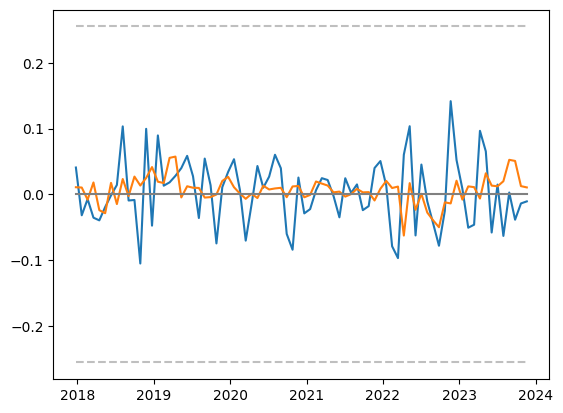

In [11]:
ticker = random.choice(tickers)

plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['real'])
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['prediction'])
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['zero'], color='grey')

band = 0.255
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['zero']-band, color= 'grey', alpha = 0.5, linestyle='dashed')
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['zero']+band, color= 'grey', alpha= 0.5, linestyle='dashed')

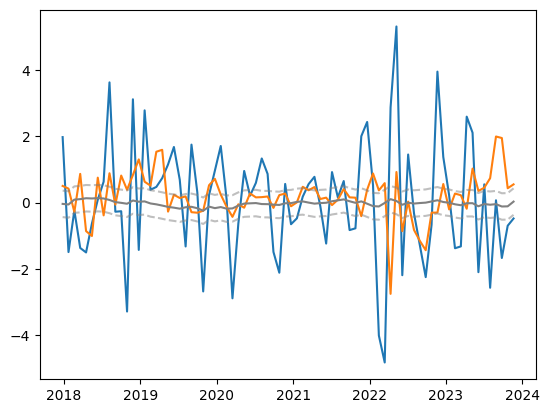

In [12]:
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['Real'])
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['Prediction'])
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['Zero'], color='grey')

band = 0.4
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['Zero']-band, color= 'grey', alpha = 0.5, linestyle='dashed')
plt.plot(collect_df[ collect_df['Ticker']== ticker]['Date'], collect_df[ collect_df['Ticker']== ticker]['Zero']+band, color= 'grey', alpha= 0.5, linestyle='dashed')

## Portfolios

In [13]:
forec = pd.read_csv(f'{path}/Models/{model_version}/Forecast.csv')
forec['Date'] = pd.to_datetime(forec['Date'])
forec = forec.sort_values(by='Date')
forec

,Ticker,Date,Prediction,Rank,Real,Mean,Zero,Std,Momentum3,Momentum6,Momentum11,48,49,50,51,real,prediction,Raw return predicted
0,SPG US Equity,2017-12-25,-2.552894,0,2.432891,-0.001547,0.055653,0.027788,0.000672,0.000668,-0.001547,0.045499,-0.008652,0.045539,-0.016327,0.066059,-0.072487,-0.069922
323,KMI US Equity,2017-12-25,0.900113,323,2.998406,-0.004066,0.183722,0.022130,-0.008248,-0.004372,-0.004066,0.016954,0.040335,0.002225,0.002774,0.062288,0.015853,0.015980
322,LKQ US Equity,2017-12-25,0.520410,322,2.622845,0.004496,-0.206379,0.021785,0.008780,0.007537,0.004496,0.023179,0.026628,0.001238,0.010590,0.061636,0.015833,0.015959
321,NOC US Equity,2017-12-25,0.685461,321,-0.132293,0.005752,-0.394823,0.014569,0.009630,0.006706,0.005752,-0.006830,0.013220,0.012529,-0.015094,0.003825,0.015739,0.015863
320,KHC US Equity,2017-12-25,0.757681,320,-0.706519,-0.001397,0.061843,0.022592,-0.001805,-0.005398,-0.001397,0.028603,-0.044302,0.012679,-0.014339,-0.017359,0.015721,0.015845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37482,KIM US Equity,2023-11-20,-0.057028,155,4.733792,-0.004173,0.144246,0.028929,-0.017553,-0.004182,-0.004173,0.047403,0.071459,-0.054247,0.068159,0.132773,-0.005823,-0.005806
37481,DUK US Equity,2023-11-20,-0.187089,154,1.683794,-0.000780,0.028624,0.027264,-0.006311,-0.004401,-0.000780,0.018023,0.020494,-0.030556,0.037166,0.045126,-0.005881,-0.005864
37480,TFC US Equity,2023-11-20,0.034839,153,2.986328,-0.008285,0.126228,0.065634,-0.015247,-0.004906,-0.008285,0.041665,0.086953,-0.028591,0.087692,0.187719,-0.005998,-0.005980
37478,AMZN US Equity,2023-11-20,-0.406731,151,3.897332,0.007959,-0.228368,0.034850,-0.001350,0.006742,0.007959,0.047450,0.051618,0.020190,0.024523,0.143780,-0.006216,-0.006197


In [14]:
df = pd.read_csv(f'{path}/Data/SPX_raw.csv', low_memory=False)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [15]:

# Set which period to look at
Period = 'All'

if Period == 'All':
  start = pd.to_datetime('2018-01-22')
  end = pd.to_datetime('2023-12-11')
if Period == 'One':
  start = pd.to_datetime('2017-12-25')
  end = pd.to_datetime('2019-12-31')
if Period == 'Two':
  start = pd.to_datetime('2020-01-20')
  end = pd.to_datetime('2023-12-11')


date = start

collector = pd.DataFrame([])

while date <= end:

    start_date = date - timedelta(weeks=4)

    data = forec[ forec['Date'] == date].drop(columns='Date').set_index('Ticker')

    spx = df[ (df['Date'] <= date) & (df['Date'] > start_date)][['Ticker', '1W Tot Ret', 'Date']]

    for i in spx['Date'].unique():
        spx_i = spx[ spx['Date'] == i].set_index('Ticker')

        # spx_i['Date'] = spx_i['Date'] + timedelta(weeks=4)

        conc = pd.concat([spx_i, data], axis=1)

        collector = pd.concat([collector, conc])

    date = date + timedelta(weeks=4)

Forecast = collector.dropna()
Forecast

,1W Tot Ret,Date,Prediction,Rank,Real,Mean,Zero,Std,Momentum3,Momentum6,Momentum11,48,49,50,51,real,prediction,Raw return predicted
Ticker,,,,,,,,,,,,,,,,,,
TXN US Equity,0.2977,2018-01-01,-0.036294,206.0,6.439079,0.007159,-0.354536,0.020192,0.013880,0.011444,0.007159,0.002973,0.048589,0.027705,0.057908,0.137174,0.006426,0.006447
CRM US Equity,-0.3897,2018-01-01,0.281442,304.0,4.104610,0.006214,-0.286379,0.021700,0.008019,0.005867,0.006214,-0.003905,0.062838,0.012597,0.023754,0.095284,0.012322,0.012398
RL US Equity,2.3529,2018-01-01,-0.104807,110.0,3.046235,0.003116,-0.077360,0.040282,0.011201,0.013327,0.003116,0.023256,0.012174,0.017285,0.073111,0.125826,-0.001106,-0.001105
2078185D US Equity,1.0793,2018-01-01,0.466313,397.0,2.027066,0.005998,-0.201920,0.029706,0.012343,0.004558,0.005998,0.010735,0.027423,0.015049,0.013007,0.066214,0.019850,0.020049
CELG US Equity,-1.8527,2018-01-01,0.316517,298.0,-0.770062,-0.001140,0.027821,0.040974,-0.023829,-0.008853,-0.001140,-0.018701,-0.001726,0.017319,-0.029584,-0.032692,0.011829,0.011899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGR US Equity,-1.5872,2023-11-20,-0.649595,102.0,1.088933,0.004400,-0.144621,0.030427,0.015696,0.004877,0.004400,0.011080,0.019400,0.023052,-0.015999,0.037533,-0.015365,-0.015247
RSG US Equity,0.6944,2023-11-20,0.803165,371.0,4.894594,0.003061,-0.155660,0.019666,-0.004802,0.001712,0.003061,0.019406,0.049033,0.023959,0.006920,0.099318,0.018856,0.019035
AIZ US Equity,-0.1602,2023-11-20,1.209011,461.0,3.552026,0.005197,-0.179295,0.028986,0.008708,0.008707,0.005197,0.006921,0.098577,0.004261,-0.001603,0.108155,0.040241,0.041062


In [16]:
# This code checks that the mathcing of dates from the forecasting data and the real data is performed correctly, it will give an error if there is a mismatch in values
# The warning Dataframe warning is okay

# ticker = random.choice(tickers)
# Forecast['Check'] = np.log(1 + Forecast['1W Tot Ret'].astype(float)/100)
# assert (Forecast[Forecast.index == ticker].iloc[-4:, -1].values == Forecast[Forecast.index == ticker].iloc[-1, 11:15].values).all, f'The array {Forecast[Forecast.index == ticker].iloc[-4:, -1].values} should be equal to {Forecast[Forecast.index == ticker].iloc[-1, 11:15].values}, this means there is a problem with the mathcing!'

# print(f'Everything is good, {Forecast[Forecast.index == ticker].iloc[-4:, -1].values} & {Forecast[Forecast.index == ticker].iloc[-1, 11:15].values} are identical!')


In [17]:
# Creating the Forecast portfolios

dates = Forecast['Date'].unique()

value_spx = 100
value_forec = 100

short_port_prev = pd.DataFrame([])
long_port_prev = pd.DataFrame([])

turnover = 0

collector = [[pd.to_datetime(Forecast['Date'].unique()[0]) - timedelta(weeks=1), 100, 100,]]

for d in dates[:]:
    period_df = Forecast[Forecast['Date'] == d].sort_values(by='Prediction')

    period_df['1W Tot Ret'] = period_df['1W Tot Ret'].astype(float)

    returns = period_df['1W Tot Ret'].mean() / 100

    short_port = period_df.iloc[:20]
    long_port  = period_df.iloc[-20:]

    # band = 0.25 # NegCorr
    # band = 0.1 # MSE
    # band = 0.1 # LSTM
    # band = 0.02 # MSE Single
    # short_port = period_df[ period_df['Raw return predicted'] < 0 - band]
    # long_port  = period_df[ period_df['Raw return predicted'] > 0 + band]

    count = long_port['1W Tot Ret'].count()

    short = - short_port['1W Tot Ret'].mean()/100
    long_ =  long_port['1W Tot Ret'].mean()/100

    if np.isnan(long_):
        long_ = 0
    if np.isnan(short):
        short = 0

    # Calculate turnover
    turnover = turnover + len(short_port[ ~short_port.index.isin(short_port_prev.index)]) + len(long_port[ ~long_port.index.isin(long_port_prev.index)])

    corr = period_df[['prediction', 'real']].corr().iloc[1, 0]

    value_spx = value_spx * (1 + returns)

    value_forec = value_forec * (1 +  long_    )
    collector.append([d, value_spx, value_forec, returns, long_, short, (long_ ), corr, count])

Forecast_index = pd.DataFrame(collector, columns= ['Date', 'SPX_index', 'Forecast_index', 'Return', 'Long', 'Short', 'Forecast Return', 'Correlation', 'Number of tickers in portfolio'])
print(Forecast_index['Number of tickers in portfolio'].mean())
Forecast_index

20.0


,Date,SPX_index,Forecast_index,Return,Long,Short,Forecast Return,Correlation,Number of tickers in portfolio
0,2017-12-25,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,99.906286,100.271070,-0.000937,0.002711,0.004213,0.002711,-0.043596,20.0
2,2018-01-08,102.369952,102.640681,0.024660,0.023632,-0.044040,0.023632,-0.043596,20.0
3,2018-01-15,103.677981,103.854848,0.012777,0.011829,-0.012279,0.011829,-0.043596,20.0
4,2018-01-22,104.950628,106.534018,0.012275,0.025797,-0.001344,0.025797,-0.043596,20.0
...,...,...,...,...,...,...,...,...,...
304,2023-10-23,166.446353,206.551226,-0.041414,-0.029883,0.054249,-0.029883,-0.059429,20.0
305,2023-10-30,164.649554,203.390217,-0.010795,-0.015304,0.023237,-0.015304,0.090408,20.0
306,2023-11-06,172.182394,211.744460,0.045751,0.041075,-0.044486,0.041075,0.090408,20.0
307,2023-11-13,171.696398,211.108909,-0.002823,-0.003001,0.012956,-0.003001,0.090408,20.0


In [18]:
#Forecast_index.to_excel(f'{path}/Models/{model_version}/Portfolio_{Period}.xlsx', index=False)

Sharpe-Ratio SPX: 1.4870647733998323
Std SPX: 0.03010504562808061
Sharpe-Ratio Forecast: 1.9789207056197644
Std Forecast: 0.03411141133258738


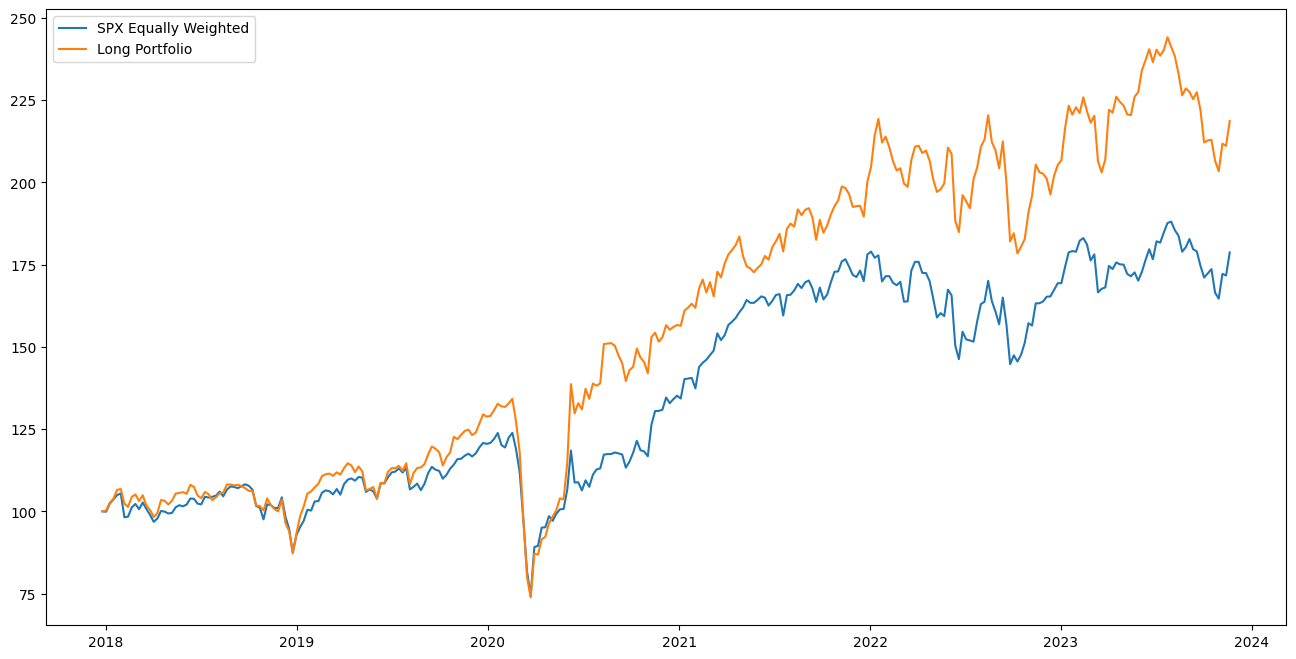

In [19]:
begin = 0
cut = 400

plt.figure(figsize=(16,8))
plt.plot(Forecast_index['Date'][begin:cut], Forecast_index[['SPX_index']][begin:cut], label= 'SPX Equally Weighted')
plt.plot(Forecast_index['Date'][begin:cut], Forecast_index[['Forecast_index']][begin:cut], label= 'Long Portfolio')
plt.legend()

sr_spx = ((Forecast_index['SPX_index'].iloc[-1] - 100) ) / Forecast_index['Return'].std()
sr_forc = ((Forecast_index['Forecast_index'].iloc[-1] - 100) ) / Forecast_index['Forecast Return'].std()
std_spx = Forecast_index['Return'].std()
std_forc = Forecast_index['Forecast Return'].std()
print(f'Sharpe-Ratio SPX: {sr_spx/100 / math.sqrt(len(Forecast_index))}')
print(f'Std SPX: {std_spx}')
print(f'Sharpe-Ratio Forecast: {sr_forc/100 / math.sqrt(len(Forecast_index))}')
print(f'Std Forecast: {std_forc}')

In [33]:
# Creating the momentum portfolios

dates = Forecast['Date'].unique()

value_spx = 100
value_mom3 = 100
value_mom6 = 100
value_mom11 = 100

short_port_prev = pd.DataFrame([])
long_port_prev = pd.DataFrame([])

turnover = 0

collector = [[pd.to_datetime(Forecast['Date'].unique()[0]) - timedelta(weeks=1), 100, 100, 100, 100]]

for d in dates[:]:

    # SPX
    returns = period_df['1W Tot Ret'].mean() / 100

    value_spx = value_spx * (1 + returns)

    # Momentum 3
    period_df = Forecast[Forecast['Date'] == d].sort_values(by='Momentum3')

    period_df['1W Tot Ret'] = period_df['1W Tot Ret'].astype(float)

    short_mom = period_df.iloc[:20]
    long_mom  = period_df.iloc[-20:]

    short = - short_mom['1W Tot Ret'].mean()/100
    long_ =  long_mom['1W Tot Ret'].mean()/100

    value_mom3 = value_mom3 * (1 + (long_ ) )
    ret3 = long_

    # Momentum 6
    period_df = Forecast[Forecast['Date'] == d].sort_values(by='Momentum6')

    period_df['1W Tot Ret'] = period_df['1W Tot Ret'].astype(float)

    short_mom = period_df.iloc[:20]
    long_mom  = period_df.iloc[-20:]

    short = - short_mom['1W Tot Ret'].mean()/100
    long_ =  long_mom['1W Tot Ret'].mean()/100

    value_mom6 = value_mom6 * (1 + (long_ ) )
    ret6 = long_

    # Momentum 11
    period_df = Forecast[Forecast['Date'] == d].sort_values(by='Momentum11')

    period_df['1W Tot Ret'] = period_df['1W Tot Ret'].astype(float)

    short_mom = period_df.iloc[:20]
    long_mom  = period_df.iloc[-20:]

    short = - short_mom['1W Tot Ret'].mean()/100
    long_ =  long_mom['1W Tot Ret'].mean()/100

    value_mom11 = value_mom11 * (1 + (long_ ) )

    ret11 = long_

    collector.append([d, value_spx, value_mom3, value_mom6, value_mom11, returns,  ret3, ret6, ret11])

Momentum_index = pd.DataFrame(collector, columns= ['Date', 'SPX_index', 'Momentum 3', 'Momentum 6', 'Momentum 11', 'Return SPX', 'Return 3', 'Return 6', 'return 11'])
Momentum_index.to_excel(f'{path}/Models/Portfolio_Momentum.xlsx', index=False)